In [1]:
import torch
from torch import Tensor
import torch.nn as nn

# resnet

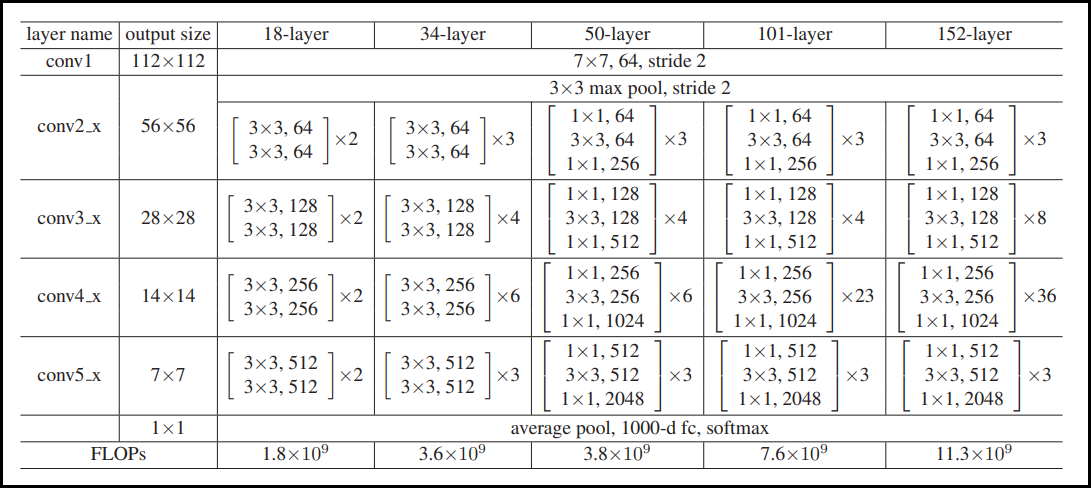

# 1. BasicBlock(18,34Residual)과 BottleNeck(50,101,152Residual)구조 제작 

In [2]:
class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias = False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
    
    def forward(self, x:Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += self.residual(out)
        
        x = self.relu2(x)

        return x


In [3]:
class BottleNeck(nn.Module):
    expansion_factor = 4
    def __init__(self, in_channels:int, out_channels:int, stride:int =1):
        super(BottleNeck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion_factor)

        self.relu3 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion_factor))
    
    def forward(self, x:Tensor)->Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x += self.residual(out)
        x = self.relu3(x)

        return x

# 모델 합치기

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_class = 10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))
        self.fc = nn.Linear(512 * block.expansion_factor, num_class)

        self.__init_layer

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)
    
    def __init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x:Tensor)-> Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x


In [8]:
class Model:
    def resnet18(self):
        return ResNet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return ResNet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return ResNet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return ResNet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return ResNet(BottleNeck, [3, 8, 36, 3])

In [9]:
model = Model().resnet152()
y = model(torch.randn(1,3,224,224))
print(y.size())

torch.Size([1, 10])
